### Import libraries and dataset connection

In [1]:
import os, sys
import re
from typing import List
from collections.abc import Callable

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'
sns.set(rc = {'figure.figsize':(15, 8)})

top_h_legend = dict(orientation='h', yanchor="bottom", y=1.02)

In [6]:
from ipywidgets import interact, interact_manual, FloatSlider

In [7]:
sys.path.append(os.path.abspath('..'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, load_dataset, \
                      fetch_data, preprocess, create_dataset, Preprocessor, standardise_column_names, \
                          ASSETS_DIR

CONNECTION_DIR = '/Users/adhaene/Downloads/'
plt.style.use(os.path.join(ASSETS_DIR, 'graphmel.mplstyle'))


## Import data

In [9]:
files = os.listdir(os.path.join(ASSETS_DIR, 'results'))

files = sorted(list(zip(
    map(lambda fpath: os.path.getmtime(os.path.join(ASSETS_DIR, 'results', fpath)), files),
    files)), key=lambda t: t[0], reverse=True)

files[:6]

[(1639417603.1498682, 'TRAIN_METRICS_2021-12-13 18:42:30.087070.csv'),
 (1639417229.7001288, 'hpopt-reduced-feats.json'),
 (1639403800.5351427, 'TRAIN_METRICS_2021-12-13 14:54:19.625171.csv'),
 (1639391413.0403504, 'TRAIN_METRICS_2021-12-13 11:28:24.549444.csv'),
 (1639310767.0595803, 'TRAIN_METRICS_2021-12-12 12:59:22.269245.csv'),
 (1639310354.2191226, 'TRAIN_METRICS_2021-12-12 12:52:31.374146.csv')]

In [8]:
results_files = [
    ('Unregularized', 'TRAIN_METRICS_2021-12-08 12:56:37.091146.csv'),
    ('Regularized', 'TRAIN_METRICS_2021-12-08 14:31:22.425463.csv')
]

df = pd.DataFrame()

for name, filename in results_files:
    
    tdf = pd.read_csv(os.path.join(ASSETS_DIR, 'results', filename), index_col=0)
    tdf['run'] = name
    
    tdf.reset_index(inplace=True)
    
    df = pd.concat([df, tdf])
    
df.reset_index(inplace=True)

In [10]:
results_files = [
    # (0.5, 'TRAIN_METRICS_2021-12-12 12:59:22.269245.csv'),
    # (1.0, 'TRAIN_METRICS_2021-12-12 12:52:31.374146.csv'),
    # (0.75, 'TRAIN_METRICS_2021-12-12 12:00:28.802609.csv'),
    # (0.0, 'TRAIN_METRICS_2021-12-12 11:53:07.344919.csv'),
    (0.25, 'TRAIN_METRICS_2021-12-12 11:38:23.871063.csv'),    
]

df = pd.DataFrame()

for name, filename in results_files:
    
    tdf = pd.read_csv(os.path.join(ASSETS_DIR, 'results', filename), index_col=0)
    tdf['run'] = name
    
    tdf.reset_index(inplace=True)
    
    df = pd.concat([df, tdf])
    
df.reset_index(inplace=True)

In [11]:
# df[df.metric == 'Accuracy - validation'].step.plot()

px.line(df[df.metric == 'Accuracy - validation'], x=df[df.metric == 'Accuracy - validation'].index, y='step')

In [12]:
df['ensemble'] = 0
df['ensemble'].loc[0:363] = 1
df['ensemble'].loc[363:723] = 2
df['ensemble'].loc[723:1083] = 3
df['ensemble'].loc[1083:] = 4

In [13]:
df

,level_0,index,metric,value,step,run,ensemble
0,0,0,Loss - training,21.503019,0,Unregularized,1
1,1,1,Accuracy - training,0.580645,0,Unregularized,1
2,2,2,Loss - validation,0.328622,0,Unregularized,1
3,3,3,Accuracy - validation,0.677419,0,Unregularized,1
4,4,4,Loss - training,20.904490,1,Unregularized,1
...,...,...,...,...,...,...,...
1435,355,355,Accuracy - validation,0.548387,88,Regularized,4
1436,356,356,Loss - training,0.010441,89,Regularized,4
1437,357,357,Accuracy - training,1.000000,89,Regularized,4
1438,358,358,Loss - validation,0.713572,89,Regularized,4


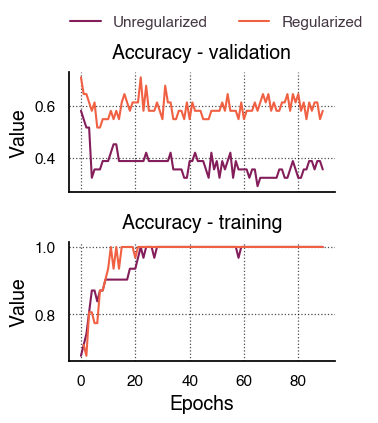

In [42]:
filtered_df = df[(df.metric.isin(['Accuracy - training', 'Accuracy - validation']))
                 & (df.ensemble.isin([2, 4]))]

golden_ratio = (5 ** 0.5 - 1) / 2
latex_width = 5.0  # in inches

g = sns.FacetGrid(data=filtered_df,
                  row='metric', sharey=False, height=latex_width * golden_ratio / 1.5, aspect=2)

g.map_dataframe(sns.lineplot, x='step', y='value', hue='run', palette=sns.color_palette("rocket", n_colors=2))
g.add_legend(loc="upper center", bbox_to_anchor=(0.4, 1.05), ncol=2)

g.set_axis_labels("Epochs", "Value")
g.set_titles(row_template="{row_name}")


#########
filename = '../report/figures/regularization.png'

# Set accurate dimensions for LaTeX report

plt.savefig(filename, bbox_inches='tight')

In [71]:
tf1 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 21:15:18.817083.csv'),
    index_col=0)
tf1['suspicious'] = 0.75

tf2 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 21:02:12.968217.csv'),
    index_col=0)
tf2['suspicious'] = 0.0

tf3 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 20:55:59.367823.csv'),
    index_col=0)
tf3['suspicious'] = 0.5

tf = pd.concat([tf1, tf2, tf3]).reset_index(drop=True)

tf

,metric,value,suspicious
0,Accuracy - testing,0.411765,0.75
1,ROC AUC - testing,0.392857,0.75
2,Precision - testing,0.500000,0.75
3,Recall - testing,0.500000,0.75
4,Fscore - testing,0.500000,0.75
5,Accuracy - testing,0.458333,0.00
6,ROC AUC - testing,0.433333,0.00
7,Precision - testing,0.571429,0.00
8,Recall - testing,0.533333,0.00
9,Fscore - testing,0.551724,0.00


In [72]:
tf.pivot(index='suspicious', columns='metric')

value                                       \
metric     Accuracy - testing Fscore - testing Precision - testing   
suspicious                                                           
0.00                 0.458333         0.551724            0.571429   
0.50                 0.666667         0.750000            0.818182   
0.75                 0.411765         0.500000            0.500000   

                                               
metric     ROC AUC - testing Recall - testing  
suspicious                                     
0.00                0.433333         0.533333  
0.50                0.646154         0.692308  
0.75                0.392857         0.500000

In [53]:
data = {
    'value': [0.667, 0.675, 0.600, 0.750, 0.667] + [0.529, 0.485, 0.333, 0.333, 0.333] + [0.769, 0.738, 0.750, 0.600, 0.667],
    'metric': ['Accuracy', 'ROC', 'Precision', 'Recall', 'Fscore'] * 3,
    'model': ['GraphConv'] * 5 + ['GIN'] * 5 + ['GAT'] * 5,
}

In [56]:
data = {
    'value': [0.667, 0.646, 0.818, 0.692, 0.750],
    'metric': ['Accuracy', 'ROC', 'Precision', 'Recall', 'Fscore'],
    'model': ['Time-GAT'] * 5,
}

In [57]:
results = pd.DataFrame(data)

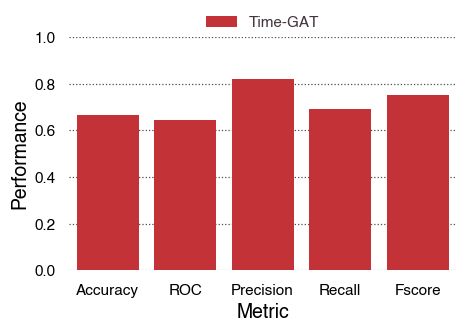

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../assets/graphmel.mplstyle')

fig, ax = plt.subplots()

sns.barplot(data=results, x='metric', y='value', hue='model', ax=ax)
    
ax.set_ylabel('Performance')
ax.set_xlabel('Metric')
ax.set_ylim((0, 1))

lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

#########
filename = '../report/figures/results_timewise.png'

# Set accurate dimensions for LaTeX report
golden_ratio = (5 ** 0.5 - 1) / 2
latex_width = 5.0  # in inches
fig.set_size_inches(latex_width, latex_width * golden_ratio)

plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')